In [13]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import os
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

## 2. Exploration des données

Une visualisation RGB des images ainsi que leurs histogrammes de couleurs permet d’avoir un aperçu de la distribution des canaux.

(224, 224, 3)


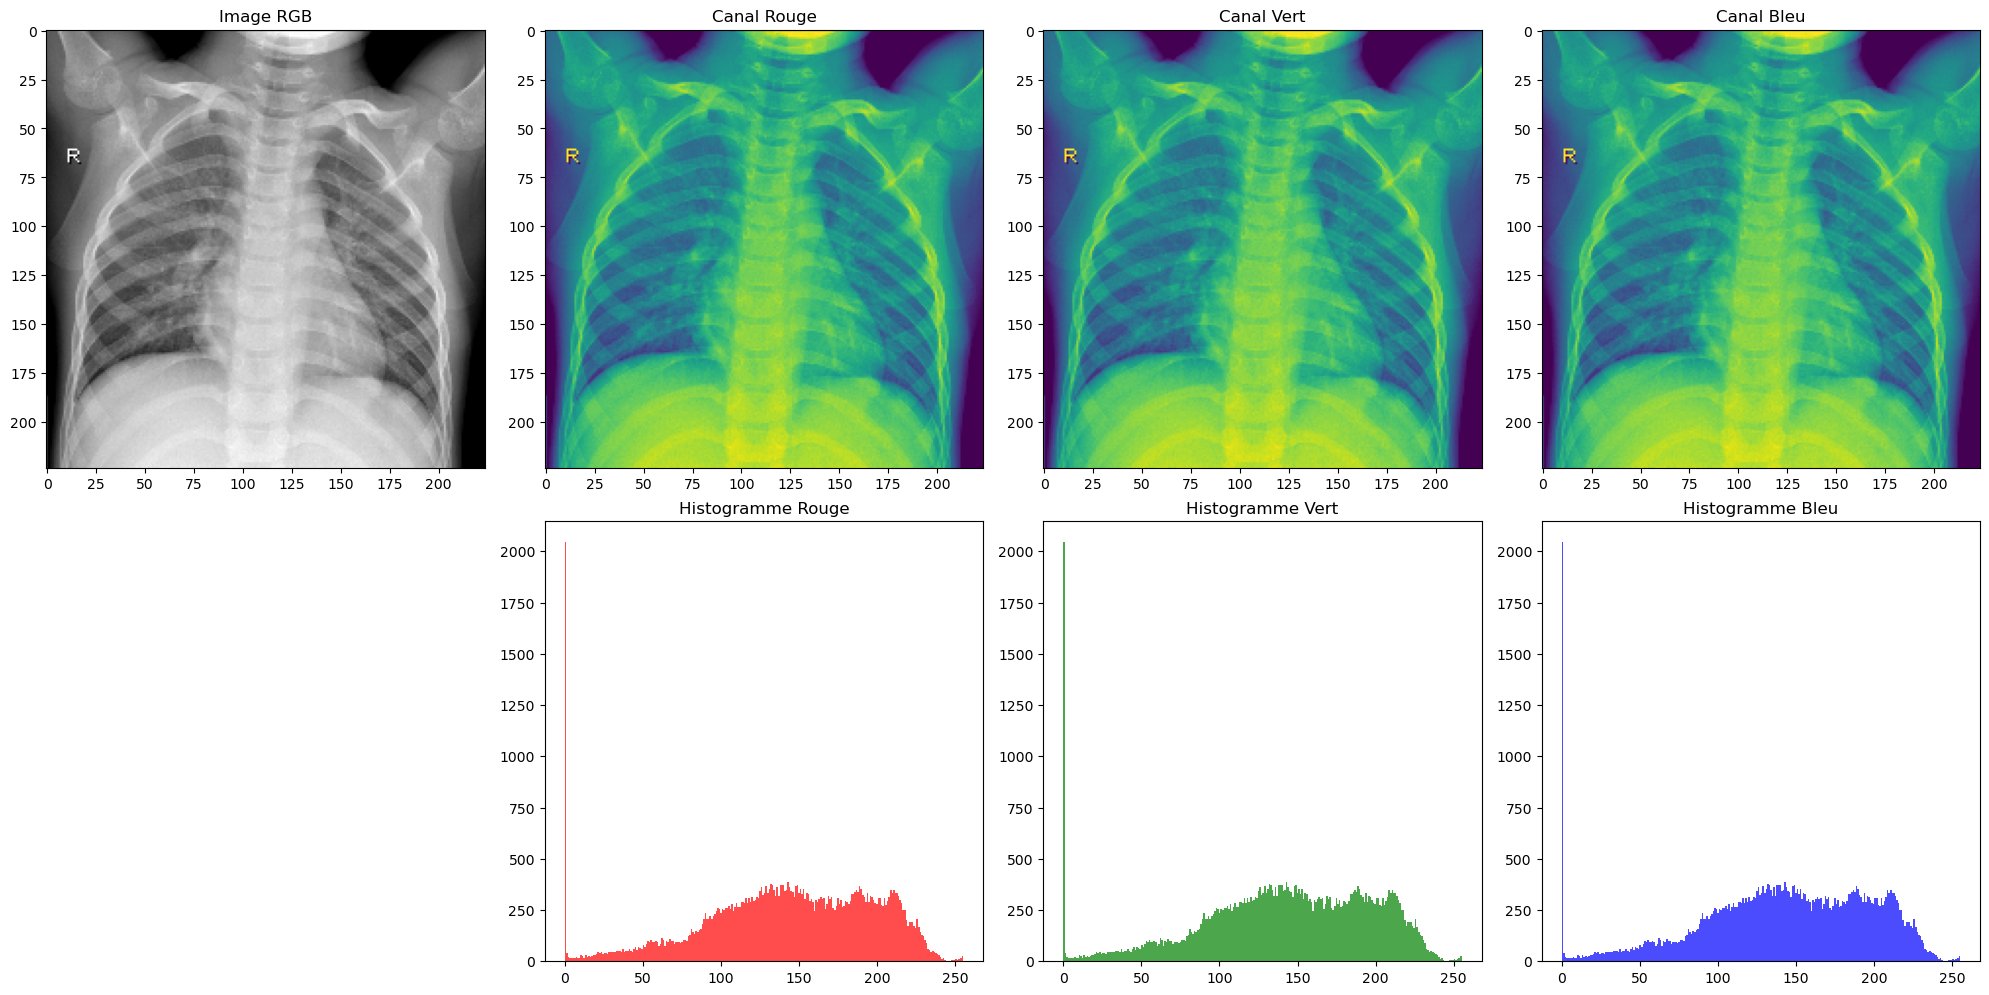

In [14]:
img = cv2.imread('../chest_Xray/train/NORMAL/IM-0172-0001.jpeg')
img = cv2.resize(img, (224, 224))
print(img.shape)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

red_channel = img_rgb[:, :, 0]
green_channel = img_rgb[:, :, 1]
blue_channel = img_rgb[:, :, 2]

fig, axs = plt.subplots(2, 4, figsize=(20, 10))

axs[0, 0].imshow(img_rgb)
axs[0, 0].set_title('Image RGB')
axs[0, 1].imshow(red_channel)
axs[0, 1].set_title('Canal Rouge')
axs[0, 2].imshow(green_channel)
axs[0, 2].set_title('Canal Vert')
axs[0, 3].imshow(blue_channel)
axs[0, 3].set_title('Canal Bleu')

# Histogrammes
axs[1, 0].axis('off')  
axs[1, 1].hist(red_channel.ravel(), bins=256, color='red', alpha=0.7)
axs[1, 1].set_title('Histogramme Rouge')
axs[1, 2].hist(green_channel.ravel(), bins=256, color='green', alpha=0.7)
axs[1, 2].set_title('Histogramme Vert')
axs[1, 3].hist(blue_channel.ravel(), bins=256, color='blue', alpha=0.7)
axs[1, 3].set_title('Histogramme Bleu')

plt.tight_layout()
plt.show()

## 3. Prétraitement des données

Le dataset utilisé est issu d’un répertoire contenant trois sous-ensembles :

- Entraînement (`train`)
- Validation (`val`)
- Test (`test`)

In [15]:
path_data = '../chest_Xray/'
path_train = os.path.join(path_data, 'train')
path_val = os.path.join(path_data, 'val')
path_test = os.path.join(path_data, 'test')

data_train = []
data_val = []
data_test = []
data = [data_train, data_val, data_test]

# iterate over the three datasets
# and append the image paths and labels to the respective lists
for i, d in enumerate([path_train, path_val, path_test]):
    normal = os.path.join(d, 'NORMAL')
    pneumonia = os.path.join(d, 'PNEUMONIA')
    
    # use glob to get all jpeg files in the directories
    normal_imgs = Path(normal).glob('*.jpeg')
    pneumonia_imgs = Path(pneumonia).glob('*.jpeg')
    
    for img in normal_imgs:
        data[i].append((str(img), 0))
    
    for img in pneumonia_imgs:
        data[i].append((str(img), 1))

### Convertion en DataFrames

In [16]:
columns = ['image', 'label']

train_df = pd.DataFrame(data_train, columns=columns)
val_df = pd.DataFrame(data_val, columns=columns)
test_df = pd.DataFrame(data_test, columns=columns)

Les images sont réparties dans trois classes : `normal`, `bacteria` et `virus`.  

In [17]:
def load_images(df, image_size=(128, 128)):
    X = []
    for path in df['image']:
        img = Image.open(path).convert('L')  # Convert to grayscale
        img = img.resize(image_size)
        img_array = np.array(img).flatten() 
        X.append(img_array)
    return np.array(X)


def cat_pneumonia_type(x):
    if 'bacteria' in x:
        output = 'bacteria'
    elif 'virus' in x:
        output = 'virus'
    else:
        output = 'normal'
    return output

train_df['type'] = train_df.image.apply(lambda x: cat_pneumonia_type(x))
print(train_df['type'].value_counts())

le = LabelEncoder()
train_df['type_encoded'] = le.fit_transform(train_df['type'])

X = load_images(train_df)
y = train_df['type_encoded'].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

type
bacteria    2530
virus       1345
normal      1341
Name: count, dtype: int64


## Random forest classifier

In [18]:
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image

In [19]:
# Random Forest Classifier
rf = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10, criterion='entropy')
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

In [20]:
# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy) 

print("Classification Report :\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.7873563218390804
Classification Report :

              precision    recall  f1-score   support

    bacteria       0.76      0.88      0.81       493
      normal       0.92      0.95      0.93       287
       virus       0.67      0.44      0.53       264

    accuracy                           0.79      1044
   macro avg       0.78      0.76      0.76      1044
weighted avg       0.78      0.79      0.77      1044



### Visualizing results

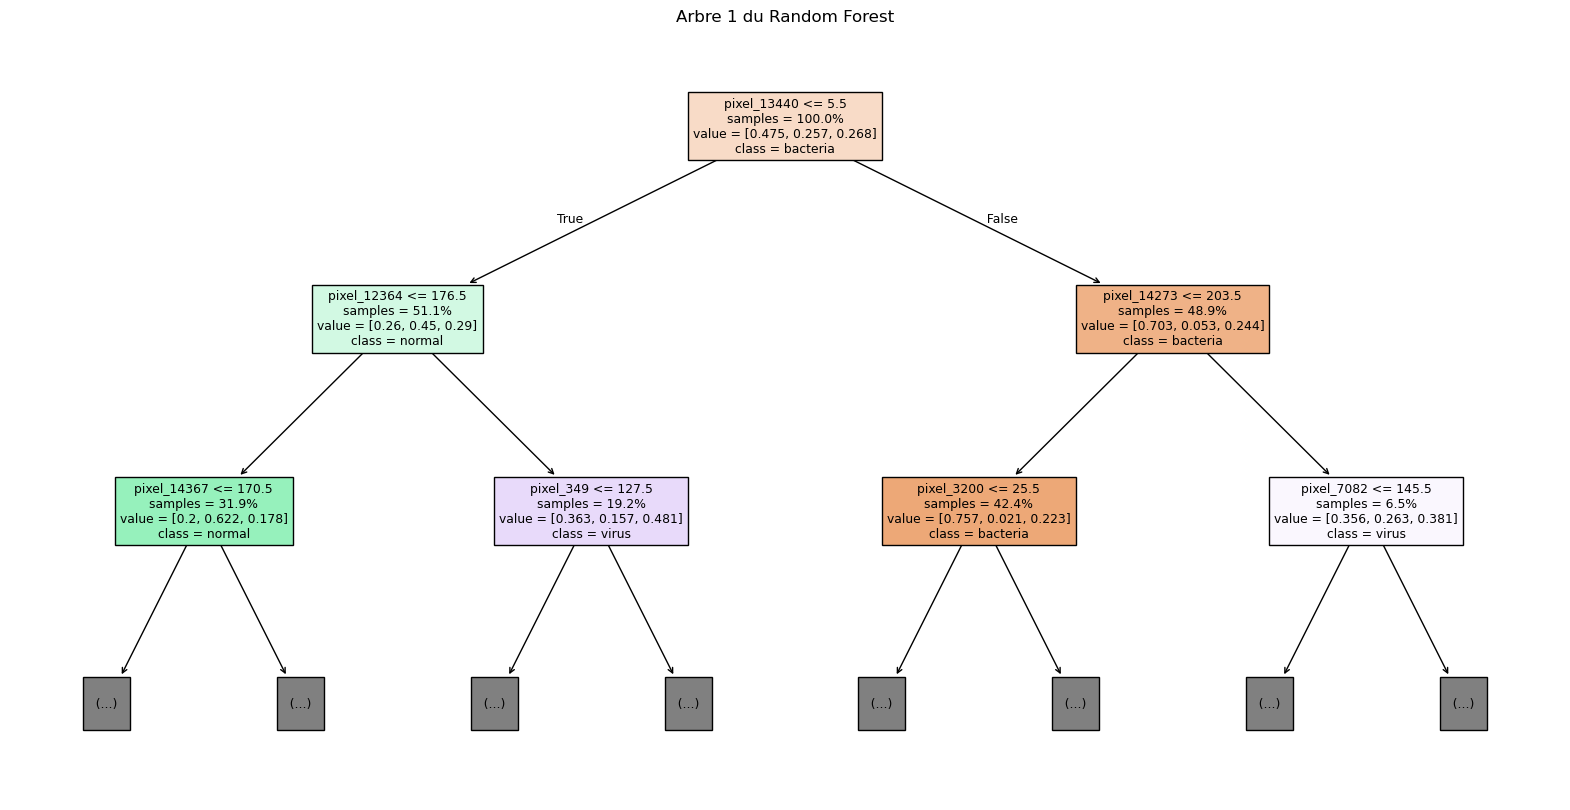

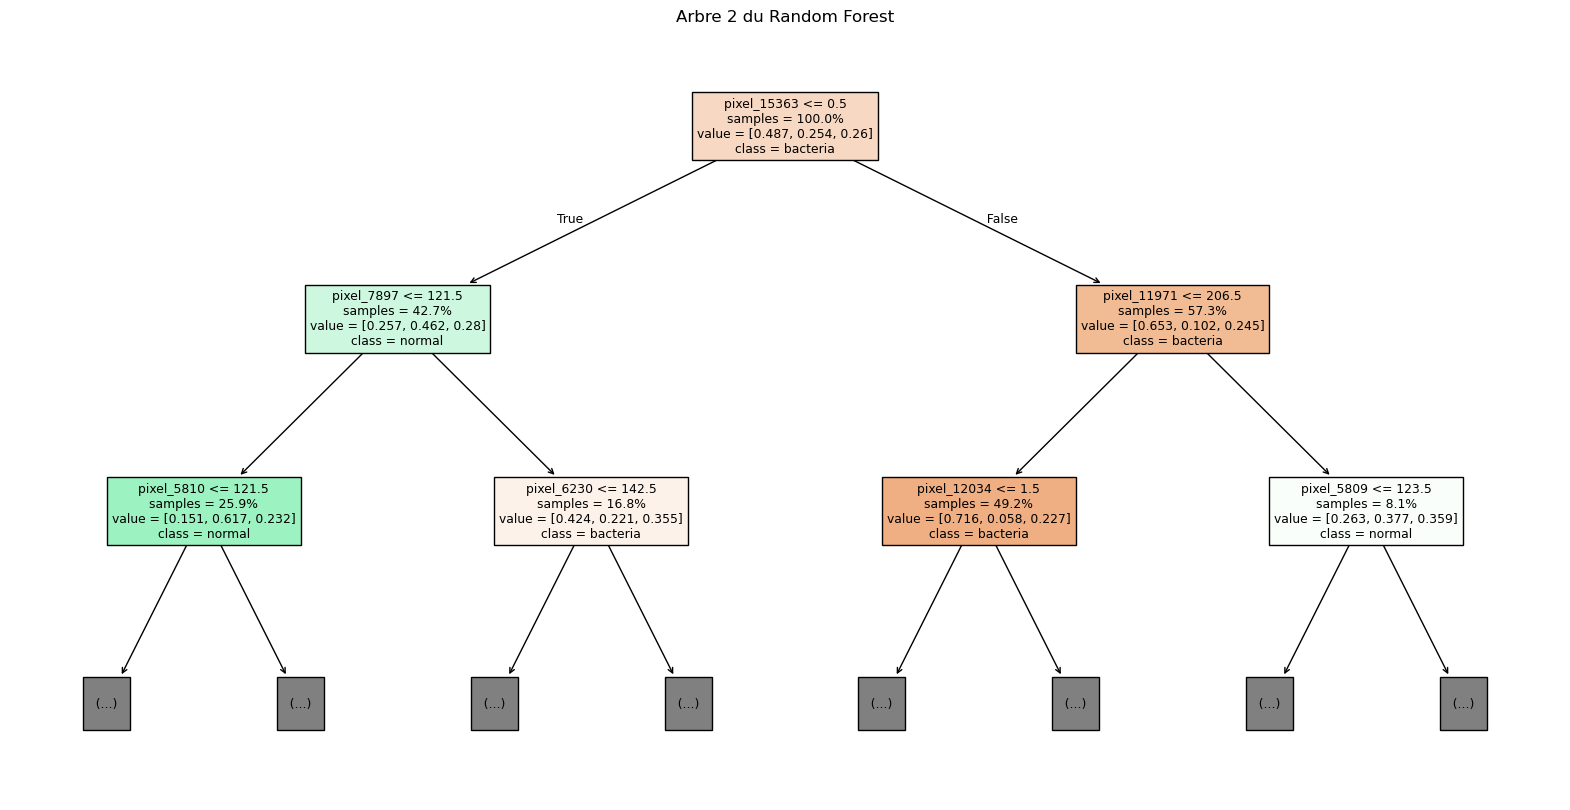

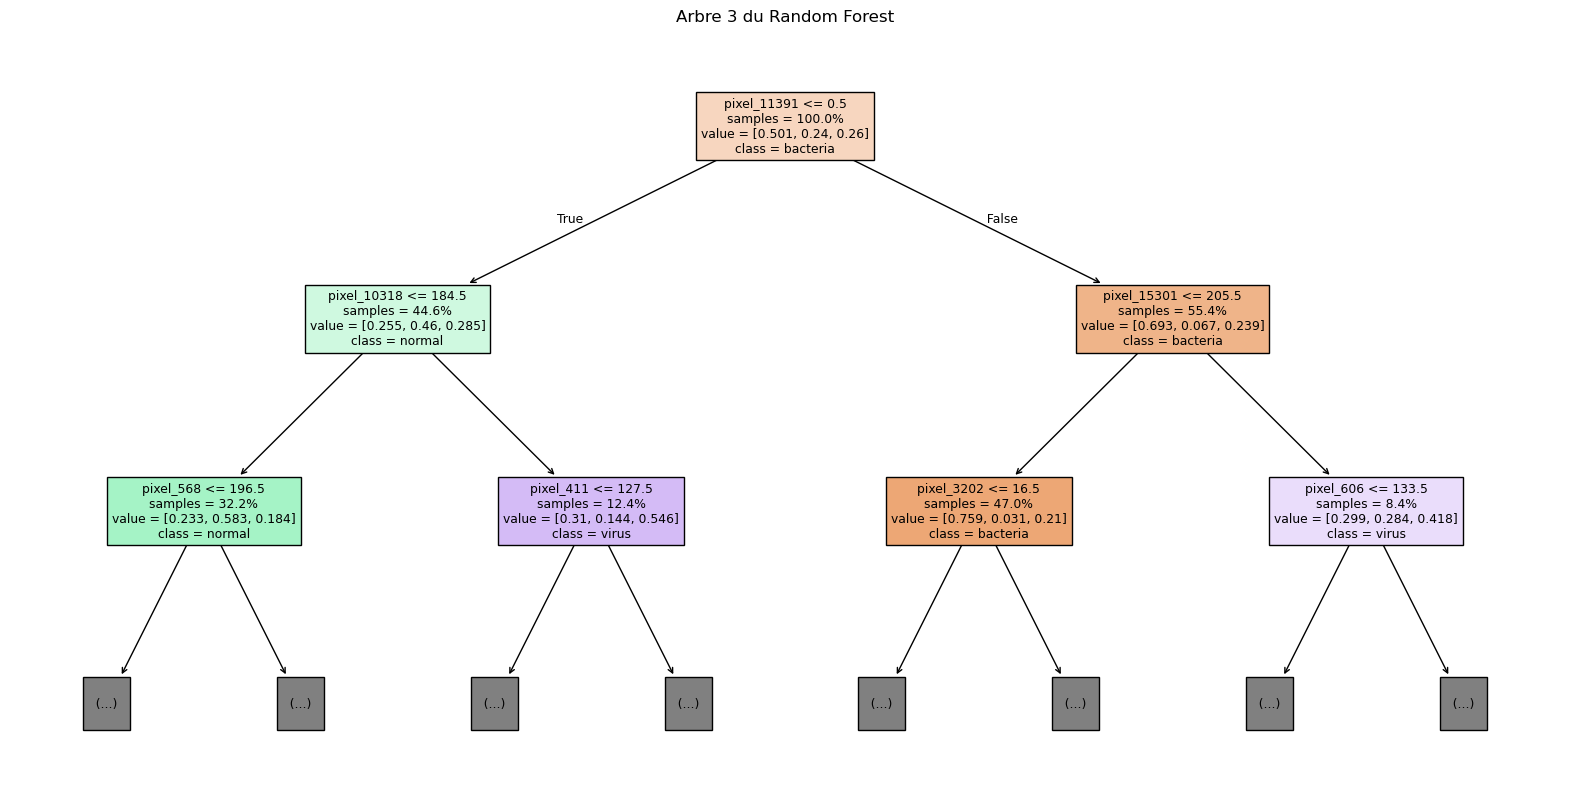

In [21]:
from sklearn.tree import plot_tree

import matplotlib.pyplot as plt

# Visualisation des 3 premiers arbres du Random Forest
for i in range(3):
    plt.figure(figsize=(20, 10))
    plot_tree(
        rf.estimators_[i],
        feature_names=[f'pixel_{j}' for j in range(X_train.shape[1])],
        class_names=le.classes_,
        filled=True,
        max_depth=2,
        impurity=False,
        proportion=True
    )
    plt.title(f'Arbre {i+1} du Random Forest')
    plt.show()


### Recherche des meilleurs hyperparamètres

In [22]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)


print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


KeyboardInterrupt: 